# Clasificación de Emociones con RNN

Implementación de una red neuronal recurrente (RNN) para clasificar emociones en tweets en español.

## Contenido

1. [Importaciones y Configuración](#1-importaciones-y-configuración)
2. [Carga y Preprocesamiento de Datos](#2-carga-y-preprocesamiento-de-datos)
4. [Arquitectura del modelo RNN](#3-arquitectura-del-modelo-rnn)
5. [Entrenamiento del modelo](#4-entrenamiento-del-modelo)
6. [Evaluación y Métricas](#5-evaluación-y-métricas)

## 1. Importaciones y Configuración

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score,
    roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
)
from sklearn.preprocessing import label_binarize

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Configuración
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Semilla para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Dispositivo utilizado: cuda


## 2. Carga y Preprocesamiento de Datos

In [2]:
# Cargar los datasets
data_path = '../data/es/'

train_df = pd.read_csv(data_path + 'train.tsv', sep='\t')
dev_df = pd.read_csv(data_path + 'dev.tsv', sep='\t')
test_df = pd.read_csv(data_path + 'test.tsv', sep='\t')

print("Datasets cargados:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(dev_df)} muestras")
print(f"Prueba: {len(test_df)} muestras")

# Crear mapeo de emociones
train_emotions = train_df['emotion'].value_counts()
emotion_to_idx = {emotion: idx for idx, emotion in enumerate(train_emotions.index)}
idx_to_emotion = {idx: emotion for emotion, idx in emotion_to_idx.items()}
num_classes = len(emotion_to_idx)
emotion_names = list(train_emotions.index)

print(f"\nEmociones: {emotion_names}")
print(f"Número de clases: {num_classes}")

Datasets cargados:
Entrenamiento: 5723 muestras
Validación: 844 muestras
Prueba: 1656 muestras

Emociones: ['others', 'joy', 'sadness', 'anger', 'surprise', 'disgust', 'fear']
Número de clases: 7


In [3]:
def clean_text(text):
    """Limpia y normaliza el texto de tweets"""
    if pd.isna(text):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF.,!?;:]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

def preprocess_dataframe(df):
    """Preprocesa un dataframe completo"""
    df = df.copy()
    df['clean_tweet'] = df['tweet'].apply(clean_text)
    df['emotion_label'] = df['emotion'].map(emotion_to_idx)
    df = df[df['clean_tweet'].str.len() > 0]
    
    return df

In [5]:
# Aplicar preprocesamiento a todos los datasets
train_clean = preprocess_dataframe(train_df)
dev_clean = preprocess_dataframe(dev_df)
test_clean = preprocess_dataframe(test_df)

In [6]:
print("Resultados del preprocesamiento:")
print(f"Entrenamiento: {len(train_df)} -> {len(train_clean)} muestras")
print(f"Validación: {len(dev_df)} -> {len(dev_clean)} muestras")
print(f"Prueba: {len(test_df)} -> {len(test_clean)} muestras")

Resultados del preprocesamiento:
Entrenamiento: 5723 -> 5723 muestras
Validación: 844 -> 844 muestras
Prueba: 1656 -> 1626 muestras


In [7]:
# Mostrar ejemplos de limpieza
print("\nEjemplos de limpieza de texto:")
for i in range(3):
    original = train_df.iloc[i]['tweet']
    cleaned = train_clean.iloc[i]['clean_tweet']
    print(f"\nOriginal: {original}")
    print(f"Limpio:   {cleaned}")


Ejemplos de limpieza de texto:

Original: La Gran Guerra de #JuegoDeTronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas https://t.co/UE7lCgLSez https://t.co/OO3tjUR34c
Limpio:   la gran guerra de juegodetronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas

Original: El golpe de Estado en #Venezuela está más lejos que el final de Elif. #VenezuelaEnBatallaYVictoria #VenezuelaNoSeRinde #VenezuelaHoy
Limpio:   el golpe de estado en venezuela está más lejos que el final de elif. venezuelaenbatallayvictoria venezuelanoserinde venezuelahoy

Original: No tengo una foto en la catedral de #NotreDame pero tengo esta secuencia hermosa... https://t.co/cwcdHASGIu
Limpio:   no tengo una foto en la catedral de notredame pero tengo esta secuencia hermosa...


### 2.1 Construcción del Vocabulario

Creamos un vocabulario a partir del texto preprocesado y implementamos funciones para tokenización y vectorización.

In [8]:
class Vocabulary:
    """Clase para manejar el vocabulario del dataset"""
    
    def __init__(self, min_freq=2, max_vocab_size=50000):
        self.min_freq = min_freq
        self.max_vocab_size = max_vocab_size
        self.word2idx = {}
        self.idx2word = {}
        self.word_frequencies = Counter()
        
        # Tokens especiales
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.sos_token = '<SOS>'
        self.eos_token = '<EOS>'
        
        # Agregar tokens especiales
        self.add_word(self.pad_token)
        self.add_word(self.unk_token)
        self.add_word(self.sos_token)
        self.add_word(self.eos_token)
    
    def add_word(self, word):
        """Agrega una palabra al vocabulario"""
        if word not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
    
    def build_vocab(self, texts):
        """Construye el vocabulario a partir de una lista de textos"""
        print("Construyendo vocabulario...")
        
        # Contar frecuencias
        for text in texts:
            words = self.tokenize(text)
            for word in words:
                self.word_frequencies[word] += 1
        
        # Agregar palabras que cumplan el criterio de frecuencia
        vocab_size_before_filter = len(self.word_frequencies)
        filtered_words = [(word, freq) for word, freq in self.word_frequencies.most_common() 
                         if freq >= self.min_freq]
        
        # Limitar tamaño del vocabulario
        if len(filtered_words) > self.max_vocab_size - 4:  # -4 por tokens especiales
            filtered_words = filtered_words[:self.max_vocab_size - 4]
        
        for word, _ in filtered_words:
            self.add_word(word)
        
        print(f"Vocabulario original: {vocab_size_before_filter} palabras")
        print(f"Vocabulario filtrado (min_freq={self.min_freq}): {len(self.word2idx)} palabras")
        print(f"Tokens especiales: {self.pad_token}(0), {self.unk_token}(1), {self.sos_token}(2), {self.eos_token}(3)")
    
    def tokenize(self, text):
        """Tokeniza un texto"""
        if pd.isna(text) or text == "":
            return []
        return text.split()
    
    def text_to_indices(self, text, add_special_tokens=True):
        """Convierte texto a lista de índices"""
        words = self.tokenize(text)
        indices = []
        
        if add_special_tokens:
            indices.append(self.word2idx[self.sos_token])
        
        for word in words:
            idx = self.word2idx.get(word, self.word2idx[self.unk_token])
            indices.append(idx)
        
        if add_special_tokens:
            indices.append(self.word2idx[self.eos_token])
        
        return indices
    
    def indices_to_text(self, indices):
        """Convierte lista de índices a texto"""
        words = []
        for idx in indices:
            if idx in self.idx2word:
                word = self.idx2word[idx]
                if word not in [self.pad_token, self.sos_token, self.eos_token]:
                    words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

In [9]:
# Crear vocabulario
vocab = Vocabulary(min_freq=1, max_vocab_size=30000)
all_texts = (train_clean['clean_tweet'].tolist())
vocab.build_vocab(all_texts)

Construyendo vocabulario...
Vocabulario original: 20544 palabras
Vocabulario filtrado (min_freq=1): 20548 palabras
Tokens especiales: <PAD>(0), <UNK>(1), <SOS>(2), <EOS>(3)


In [10]:
# Estadísticas del vocabulario
print(f"\nTamaño del vocabulario: {len(vocab)}")
print(f"Palabras más frecuentes:")
for word, freq in vocab.word_frequencies.most_common(10):
    print(f"  {word}: {freq}")


Tamaño del vocabulario: 20548
Palabras más frecuentes:
  de: 6076
  la: 3810
  que: 3754
  el: 3471
  y: 2677
  en: 2645
  a: 2519
  user: 2001
  no: 1563
  los: 1459


In [11]:
# Ejemplo de conversión
example_text = train_clean.iloc[0]['clean_tweet']
example_indices = vocab.text_to_indices(example_text)
reconstructed_text = vocab.indices_to_text(example_indices)

print(f"\nEjemplo de conversión:")
print(f"Texto original: {example_text}")
print(f"Índices: {example_indices}")
print(f"Texto reconstruido: {reconstructed_text}")


Ejemplo de conversión:
Texto original: la gran guerra de juegodetronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas
Índices: [2, 5, 103, 437, 4, 24, 50, 36, 681, 250, 453, 21, 7, 648, 8, 619, 1748, 3119, 3]
Texto reconstruido: la gran guerra de juegodetronos nos ha dejado muchos momentos para el recuerdo y unas cuantas dudas


### 2.2 Dataset y DataLoader

Implementamos la clase Dataset personalizada para manejar nuestros datos y crear los DataLoaders para entrenamiento.

In [12]:
class EmotionDataset(Dataset):
    """Dataset personalizado para clasificación de emociones"""
    
    def __init__(self, dataframe, vocabulary, max_length=None):
        self.data = dataframe.reset_index(drop=True)
        self.vocab = vocabulary
        self.max_length = max_length
        
        # Convertir textos a índices
        self.sequences = []
        self.labels = []
        
        for idx, row in self.data.iterrows():
            text = row['clean_tweet']
            label = row['emotion_label']
            
            # Convertir texto a secuencia de índices
            sequence = self.vocab.text_to_indices(text, add_special_tokens=True)
            
            # Truncar si es necesario
            if self.max_length and len(sequence) > self.max_length:
                sequence = sequence[:self.max_length]
            
            self.sequences.append(sequence)
            self.labels.append(label)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_fn(batch):
    """Función personalizada para agrupar secuencias de diferentes longitudes"""
    sequences, labels = zip(*batch)
    
    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    
    # Crear máscara de padding
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    return padded_sequences, labels, lengths

In [13]:
# Determinar longitud máxima basada en percentiles
all_lengths = []
for df in [train_clean, dev_clean, test_clean]:
    for text in df['clean_tweet']:
        seq_length = len(vocab.tokenize(text)) + 2  # +2 por SOS y EOS tokens
        all_lengths.append(seq_length)

max_length = int(np.percentile(all_lengths, 99))  # Usar el percentil 99
print(f"Longitud máxima de secuencia (percentil 99): {max_length}")

Longitud máxima de secuencia (percentil 99): 51


In [14]:
# Crear datasets
train_dataset = EmotionDataset(train_clean, vocab, max_length=max_length)
dev_dataset = EmotionDataset(dev_clean, vocab, max_length=max_length)
test_dataset = EmotionDataset(test_clean, vocab, max_length=max_length)

print(f"Tamaños de datasets:")
print(f"  Entrenamiento: {len(train_dataset)}")
print(f"  Validación: {len(dev_dataset)}")
print(f"  Prueba: {len(test_dataset)}")

Tamaños de datasets:
  Entrenamiento: 5723
  Validación: 844
  Prueba: 1626


In [15]:
# Crear DataLoaders
batch_size = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=0  # 0 para evitar problemas en Windows
)

dev_loader = DataLoader(
    dev_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=0
)

In [16]:
print(f"Número de batches:")
print(f"  Entrenamiento: {len(train_loader)}")
print(f"  Validación: {len(dev_loader)}")
print(f"  Prueba: {len(test_loader)}")

Número de batches:
  Entrenamiento: 179
  Validación: 27
  Prueba: 51


In [17]:
# Verificar un batch de ejemplo
sample_batch = next(iter(train_loader))
sequences, labels, lengths = sample_batch
print(f"\nEjemplo de batch:")
print(f"  Shape de secuencias: {sequences.shape}")
print(f"  Shape de etiquetas: {labels.shape}")
print(f"  Longitudes: {lengths}")
print(f"  Etiquetas únicas en el batch: {torch.unique(labels).tolist()}")


Ejemplo de batch:
  Shape de secuencias: torch.Size([32, 51])
  Shape de etiquetas: torch.Size([32])
  Longitudes: tensor([15,  9, 17, 33, 14, 24, 12, 11, 31, 18, 24, 33, 16, 34, 11, 35, 26, 21,
        16, 19, 17, 14, 39, 51, 19, 40, 15, 47, 23, 35,  9, 26])
  Etiquetas únicas en el batch: [0, 1, 2, 3, 4]


## 3. Arquitectura del Modelo RNN

### 3.1 Modelo RNN Avanzado

Implementamos una arquitectura RNN compleja que incluye:
- **Capa de Embedding**: Para representar palabras como vectores densos
- **RNN Bidireccional**: Para capturar contexto en ambas direcciones
- **Múltiples capas RNN**: Para mayor capacidad de modelado
- **Attention Mechanism**: Para enfocar en partes importantes del texto
- **Dropout y Regularización**: Para prevenir overfitting
- **Capas Fully Connected**: Para la clasificación final

In [18]:
class AttentionLayer(nn.Module):
    """Capa de atención para RNN"""
    
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, 1)
        
    def forward(self, rnn_outputs, lengths):

        batch_size, seq_len, hidden_size = rnn_outputs.size()
        # Calcular scores de atención
        # (batch_size, seq_len, 1)
        attention_scores = self.attention(rnn_outputs)
        attention_scores = attention_scores.squeeze(-1)  # (batch_size, seq_len)
        
        # Crear máscara para ignorar posiciones de padding
        mask = torch.arange(seq_len, device=rnn_outputs.device).expand(
            batch_size, seq_len
        ) < lengths.unsqueeze(1)
        
        # Aplicar máscara (asignar -inf a posiciones de padding)
        attention_scores = attention_scores.masked_fill(~mask, float('-inf'))
        
        # Aplicar softmax
        attention_weights = F.softmax(attention_scores, dim=1)
        
        # Calcular vector de contexto ponderado
        # (batch_size, 1, seq_len) @ (batch_size, seq_len, hidden_size) -> (batch_size, 1, hidden_size)
        context = torch.bmm(attention_weights.unsqueeze(1), rnn_outputs)
        context = context.squeeze(1)  # (batch_size, hidden_size)
        
        return context, attention_weights

class AdvancedRNNClassifier(nn.Module):
    """Clasificador RNN avanzado con atención y múltiples capas"""
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, 
                 dropout=0.2, rnn_type='LSTM', bidirectional=True, use_attention=True):
        super(AdvancedRNNClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.use_attention = use_attention
        self.rnn_type = rnn_type
        
        # Capa de embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_dropout = nn.Dropout(dropout * 0.5)
        
        # Capa RNN
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                embedding_dim, hidden_size, num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                embedding_dim, hidden_size, num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        else:
            self.rnn = nn.RNN(
                embedding_dim, hidden_size, num_layers,
                batch_first=True, dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
        
        # Tamaño de salida de RNN
        rnn_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        # Capa de atención
        if use_attention:
            self.attention = AttentionLayer(rnn_output_size)
            classifier_input_size = rnn_output_size
        else:
            classifier_input_size = rnn_output_size
        
        # Capas de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(classifier_input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # Inicialización de pesos
        self.init_weights()
    
    def init_weights(self):
        """Inicializa los pesos del modelo"""
        # Inicializar embeddings
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)  # PAD token
        
        # Inicializar pesos de RNN
        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
                # Sesgo de forget gate en LSTM
                if self.rnn_type == 'LSTM':
                    n = param.size(0)
                    start, end = n // 4, n // 2
                    param.data[start:end].fill_(1.)
        
        # Inicializar capas lineales
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, sequences, lengths):
        """
        Args:
            sequences: (batch_size, seq_len) índices de palabras
            lengths: (batch_size,) longitudes reales de las secuencias
        Returns:
            logits: (batch_size, num_classes) scores de clasificación
            attention_weights: (batch_size, seq_len) si use_attention=True
        """
        batch_size, seq_len = sequences.size()
        
        # Embedding
        embedded = self.embedding(sequences)  # (batch_size, seq_len, embedding_dim)
        embedded = self.embedding_dropout(embedded)
        
        # Empaquetar secuencias para eficiencia
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # RNN
        packed_output, _ = self.rnn(packed_embedded)
        
        # Desempaquetar
        rnn_output, _ = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # rnn_output: (batch_size, seq_len, hidden_size * num_directions)
        
        # Aplicar atención o pooling
        if self.use_attention:
            context, attention_weights = self.attention(rnn_output, lengths)
            pooled_output = context
        else:
            # Global max pooling
            pooled_output = F.adaptive_max_pool1d(
                rnn_output.transpose(1, 2), 1
            ).squeeze(-1)
            attention_weights = None
        
        # Clasificación
        logits = self.classifier(pooled_output)
        
        if self.use_attention:
            return logits, attention_weights
        else:
            return logits, None

In [20]:
# Configuración del modelo
model_config = {
    'vocab_size': len(vocab),
    'embedding_dim': 128,
    'hidden_size': 256,
    'num_layers': 2,
    'num_classes': num_classes,
    'dropout': 0.2,
    'rnn_type': 'GRU',  # 'LSTM', 'GRU', o 'RNN'
    'bidirectional': True,
    'use_attention': True
}

# Crear modelo
model = AdvancedRNNClassifier(**model_config)
model = model.to(device)

# Mostrar información del modelo
def count_parameters(model):
    """Cuenta el número de parámetros entrenables"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Configuración del modelo:")
for key, value in model_config.items():
    print(f"  {key}: {value}")
print(f"\nNúmero total de parámetros entrenables: {total_params:,}")

# Mostrar arquitectura del modelo
print(f"\nArquitectura del modelo:")
print(model)

Configuración del modelo:
  vocab_size: 20548
  embedding_dim: 128
  hidden_size: 256
  num_layers: 2
  num_classes: 7
  dropout: 0.2
  rnn_type: GRU
  bidirectional: True
  use_attention: True

Número total de parámetros entrenables: 4,572,168

Arquitectura del modelo:
AdvancedRNNClassifier(
  (embedding): Embedding(20548, 128, padding_idx=0)
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (rnn): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): AttentionLayer(
    (attention): Linear(in_features=512, out_features=1, bias=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=

In [21]:
# Prueba rápida del modelo
with torch.no_grad():
    sample_sequences, sample_labels, sample_lengths = next(iter(train_loader))
    sample_sequences = sample_sequences.to(device)
    sample_lengths = sample_lengths.to(device)
    
    logits, attention_weights = model(sample_sequences, sample_lengths)
    print(f"Prueba del modelo:")
    print(f"  Input shape: {sample_sequences.shape}")
    print(f"  Output shape: {logits.shape}")
    if attention_weights is not None:
        print(f"  Attention weights shape: {attention_weights.shape}")

Prueba del modelo:
  Input shape: torch.Size([32, 51])
  Output shape: torch.Size([32, 7])
  Attention weights shape: torch.Size([32, 51])


## 4. Entrenamiento del Modelo

### 4.1 Configuración del Entrenamiento

Configuramos el optimizador, función de pérdida, scheduler y métricas para el entrenamiento.

In [22]:
# Configuración del entrenamiento
learning_rate = 1e-4
num_epochs = 50
weight_decay = 1e-5

# Optimizador con scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Scheduler de learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10, verbose=True, min_lr=1e-6
)

# Función de pérdida con pesos de clase para el desbalance
train_emotion_counts = train_clean['emotion'].value_counts()
class_weights = torch.zeros(num_classes)
for emotion, idx in emotion_to_idx.items():
    if emotion in train_emotion_counts:
        class_weights[idx] = 1.0 / train_emotion_counts[emotion]

# Normalizar pesos
class_weights = class_weights / class_weights.sum() * num_classes
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Configuración del entrenamiento:")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")
print(f"  Weight decay: {weight_decay}")
print(f"  Optimizador: {optimizer.__class__.__name__}")
print(f"  Criterion: {criterion.__class__.__name__}")
print(f"  Pesos de clase: {class_weights.cpu().numpy()}")
print(f"  Scheduler: {scheduler.__class__.__name__}")

Configuración del entrenamiento:
  Learning rate: 0.0001
  Epochs: 50
  Weight decay: 1e-05
  Optimizador: AdamW
  Criterion: CrossEntropyLoss
  Pesos de clase: [0.07596881 0.17335996 0.3069447  0.36114207 0.8937507  1.9163303
 3.2725024 ]
  Scheduler: ReduceLROnPlateau


In [23]:
### 5.2 Funciones Auxiliares de Entrenamiento

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch_idx, (sequences, labels, lengths) in enumerate(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits, attention_weights = model(sequences, lengths)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping para evitar exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Estadísticas
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Mostrar progreso cada 100 batches
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Accuracy: {100 * correct_predictions / total_predictions:.2f}%')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def evaluate_model(model, data_loader, criterion, device):
    """Evalúa el modelo en un dataset"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels, lengths in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            logits, attention_weights = model(sequences, lengths)
            loss = criterion(logits, labels)
            
            # Estadísticas
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)
            
            # Guardar para métricas detalladas
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy, all_predictions, all_labels

In [ ]:
### 5.3 Bucle Principal de Entrenamiento

# Listas para almacenar las métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Variables para early stopping
best_val_accuracy = 0
patience_counter = 0
max_patience = 5

print("Iniciando entrenamiento...")
print("=" * 80)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 40)
    
    # Entrenar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluar en validación
    val_loss, val_acc, _, _ = evaluate_model(model, dev_loader, criterion, device)
    
    # Guardar métricas
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Mostrar resultados del epoch
    print(f"\nResultados del Epoch {epoch + 1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Scheduler step
    scheduler.step(val_acc)
    
    # Early stopping y guardado del mejor modelo
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        # Guardar mejor modelo
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_accuracy': best_val_accuracy,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'model_config': model_config,
            'vocab': vocab,
            'emotion_to_idx': emotion_to_idx
        }, '../models/best_rnn_model.pth')
        print(f"  *** Nuevo mejor modelo guardado (Val Acc: {val_acc:.4f}) ***")
    else:
        patience_counter += 1
        print(f"  Sin mejora. Patience: {patience_counter}/{max_patience}")
    
    # Early stopping
    if patience_counter >= max_patience:
        print(f"\nEarly stopping en epoch {epoch + 1}")
        break

print("\n" + "=" * 80)
print("Entrenamiento completado!")
print(f"Mejor accuracy de validación: {best_val_accuracy:.4f}")


Iniciando entrenamiento...

Epoch 1/50
----------------------------------------
Batch 0/179, Loss: 3.1106, Accuracy: 15.62%
Batch 100/179, Loss: 2.1283, Accuracy: 15.25%

Resultados del Epoch 1:
  Train Loss: 2.3651, Train Acc: 0.1723
  Val Loss: 1.9575, Val Acc: 0.2002
  Learning Rate: 0.000100
  *** Nuevo mejor modelo guardado (Val Acc: 0.2002) ***

Epoch 2/50
----------------------------------------
Batch 0/179, Loss: 1.8743, Accuracy: 15.62%
Batch 100/179, Loss: 1.8325, Accuracy: 22.09%

Resultados del Epoch 2:
  Train Loss: 2.0003, Train Acc: 0.2240
  Val Loss: 1.8861, Val Acc: 0.1908
  Learning Rate: 0.000100
  Sin mejora. Patience: 1/5

Epoch 3/50
----------------------------------------
Batch 0/179, Loss: 2.1057, Accuracy: 25.00%
Batch 100/179, Loss: 2.2228, Accuracy: 25.68%

Resultados del Epoch 3:
  Train Loss: 1.8426, Train Acc: 0.2658
  Val Loss: 1.8104, Val Acc: 0.2666
  Learning Rate: 0.000100
  *** Nuevo mejor modelo guardado (Val Acc: 0.2666) ***

Epoch 4/50
-----------

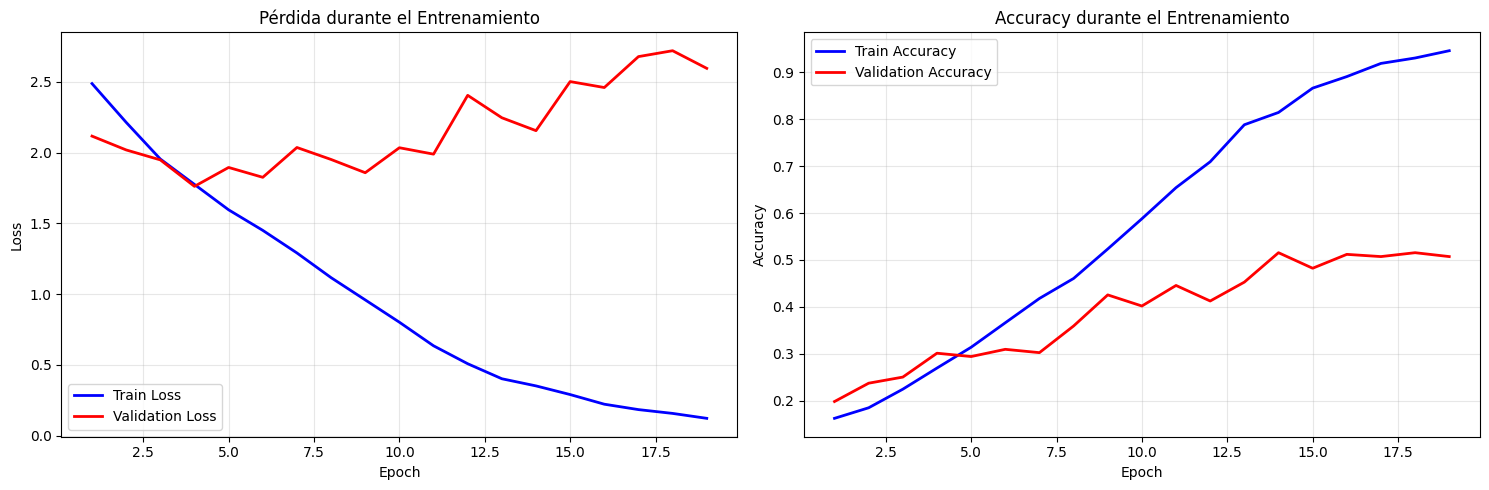


Mejores resultados:
  Epoch: 14
  Train Loss: 0.3523
  Train Accuracy: 0.8146
  Val Loss: 2.1549
  Val Accuracy: 0.5154


In [71]:
### 5.4 Visualización de Curvas de Entrenamiento

# Crear gráficos de las métricas de entrenamientosdf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de pérdida
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_title('Pérdida durante el Entrenamiento')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de accuracy
ax2.plot(epochs_range, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_title('Accuracy durante el Entrenamiento')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar mejores resultados
best_epoch = val_accuracies.index(max(val_accuracies)) + 1
print(f"\nMejores resultados:")
print(f"  Epoch: {best_epoch}")
print(f"  Train Loss: {train_losses[best_epoch-1]:.4f}")
print(f"  Train Accuracy: {train_accuracies[best_epoch-1]:.4f}")
print(f"  Val Loss: {val_losses[best_epoch-1]:.4f}")
print(f"  Val Accuracy: {val_accuracies[best_epoch-1]:.4f}")

## 5. Evaluación y Métricas

### 5.1 Carga del Mejor Modelo

Cargamos el mejor modelo guardado durante el entrenamiento para realizar la evaluación final.

In [87]:
# Cargar el mejor modelo
checkpoint = torch.load('../models/best_rnn_model.pth', map_location=device)

# Crear nuevo modelo con la misma configuración
best_model = AdvancedRNNClassifier(**checkpoint['model_config'])
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model = best_model.to(device)

print("Mejor modelo cargado exitosamente!")
print(f"Epoch del mejor modelo: {checkpoint['epoch'] + 1}")
print(f"Mejor accuracy de validación: {checkpoint['best_val_accuracy']:.4f}")

Mejor modelo cargado exitosamente!
Epoch del mejor modelo: 14
Mejor accuracy de validación: 0.5154


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve)
from sklearn.preprocessing import label_binarize

class EvaluadorMulticlase:
    def __init__(self, classes):
        self.classes = list(classes)

    def show_classification_report(self, y_true_str, y_pred_str, title="Classification report"):
        df_rep = pd.DataFrame(
            classification_report(
                y_true_str, y_pred_str,
                labels=self.classes, target_names=self.classes,
                output_dict=True, zero_division=0
            )
        ).T.round(4)
        print(f"== {title} ==")
        display(df_rep)

    def show_confusion_matrix(self, y_true_str, y_pred_str, title="Matriz de confusión"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])
        y_pred_id = np.array([label2id[x] for x in y_pred_str])

        cm = confusion_matrix(y_true_id, y_pred_id, labels=list(range(len(self.classes))))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title(title); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout()
        plt.show()

    def show_roc_curves(self, y_true_str, probs, title="Curvas ROC (OvR)"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])

        Y_bin = label_binarize(y_true_id, classes=list(range(len(self.classes))))
        n = len(self.classes)
        rows = int(np.ceil(n/4))
        fig, axes = plt.subplots(rows, 4, figsize=(5*4, 4*rows))
        axes = np.atleast_2d(axes)
        auc_macro = None
        try:
            auc_macro = roc_auc_score(Y_bin, probs, average="macro", multi_class="ovr")
        except ValueError:
            pass

        for i, c in enumerate(self.classes):
            r, col = divmod(i, 4)
            ax = axes[r, col]
            try:
                fpr, tpr, _ = roc_curve(Y_bin[:, i], probs[:, i])
                auc_i = roc_auc_score(Y_bin[:, i], probs[:, i])
                ax.plot(fpr, tpr, label=f"AUC={auc_i:.3f}")
            except ValueError:
                ax.plot([0,1],[0,1],'--', lw=1)
                ax.text(0.5, 0.5, "Sin positivos", ha="center")
            ax.plot([0,1],[0,1],'--', lw=1)
            ax.set_title(f"ROC: {c}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right")

        # elimina ejes sobrantes
        total = rows*3
        if total > n:
            for j in range(n, total):
                r, col = divmod(j, 4)
                fig.delaxes(axes[r, col])

        supt = f"{title}" + (f" | AUC macro={auc_macro:.3f}" if auc_macro is not None else "")
        fig.suptitle(supt)
        plt.tight_layout()
        plt.show()

    def show_pr_curves(self, y_true_str, probs, title="Curvas Precision-Recall (OvR)"):
        label2id = {c:i for i, c in enumerate(self.classes)}
        y_true_id = np.array([label2id[x] for x in y_true_str])

        Y_bin = label_binarize(y_true_id, classes=list(range(len(self.classes))))
        n = len(self.classes)
        rows = int(np.ceil(n/4))
        fig, axes = plt.subplots(rows, 4, figsize=(5*4, 4*rows))
        axes = np.atleast_2d(axes)

        for i, c in enumerate(self.classes):        
            r, col = divmod(i, 4)
            ax = axes[r, col]
            try:
                precision, recall, _ = precision_recall_curve(Y_bin[:, i], probs[:, i])
                ap = average_precision_score(Y_bin[:, i], probs[:, i])
                ax.plot(recall, precision, label=f"AP={ap:.3f}")
            except ValueError:
                ax.plot([0,1],[1,0],'--', lw=1)
                ax.text(0.5, 0.5, "Sin positivos", ha="center")
            ax.set_title(f"PR: {c}")
            ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
            ax.legend(loc="lower left")

        total = rows*3
        if total > n:
            for j in range(n, total):
                r, col = divmod(j, 3)
                fig.delaxes(axes[r, col])

        fig.suptitle(title)
        plt.tight_layout()
        plt.show()


    # --- Análisis por evento (bloques con mini-tablas de distribuciones) ---
    def show_event_analysis(self, df, probs, y_col="emotion", event_col="event", title="Análisis por evento"):
        pred_ids = probs.argmax(axis=1)
        pred_str = np.array([self.classes[i] for i in pred_ids])

        tmp = df[[y_col, event_col]].copy()
        tmp["pred"] = pred_str

        print(f"== {title} ==")
        for event in sorted(tmp[event_col].unique()):
            sub = tmp[tmp[event_col] == event]

            # distribuciones
            dist_real = sub[y_col].value_counts().reindex(self.classes, fill_value=0)
            dist_pred = sub["pred"].value_counts().reindex(self.classes, fill_value=0)

            # métricas
            report = classification_report(
                sub[y_col], sub["pred"],
                labels=self.classes, target_names=self.classes,
                output_dict=True, zero_division=0
            )
            acc = accuracy_score(sub[y_col], sub["pred"])
            f1m = f1_score(sub[y_col], sub["pred"], average="macro")
            prec = report["macro avg"]["precision"]
            rec = report["macro avg"]["recall"]

            # mostrar métricas
            print(f"\nEvento: {event}")
            print(f"  Accuracy:        {acc:.4f}")
            print(f"  F1-macro:        {f1m:.4f}")
            print(f"  Precision-macro: {prec:.4f}")
            print(f"  Recall-macro:    {rec:.4f}")

            # mostrar tablas
            df_dist = pd.DataFrame({
                "Real": dist_real,
                "Pred": dist_pred
            }).astype(int)
            display(df_dist)

### 5.2 Evaluación Completa del Modelo

Ahora utilizaremos la clase `EvaluadorMulticlase` para realizar una evaluación exhaustiva del modelo entrenado.

In [88]:
# Función para obtener predicciones y probabilidades del modelo
def get_predictions_and_probabilities(model, data_loader, device):
    """Obtiene predicciones y probabilidades del modelo"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels, lengths in data_loader:
            sequences = sequences.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            logits, _ = model(sequences, lengths)
            probabilities = F.softmax(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_predictions), np.array(all_probabilities), np.array(all_labels)

# Obtener predicciones para el conjunto de test
print("Generando predicciones para el conjunto de test...")
test_pred_ids, test_probs, test_true_ids = get_predictions_and_probabilities(best_model, test_loader, device)

# Convertir índices a nombres de emociones
test_pred_emotions = [idx_to_emotion[idx] for idx in test_pred_ids]
test_true_emotions = [idx_to_emotion[idx] for idx in test_true_ids]

print(f"Predicciones generadas para {len(test_pred_emotions)} muestras")

Generando predicciones para el conjunto de test...
Predicciones generadas para 1626 muestras


In [89]:
# Crear instancia del evaluador
evaluador = EvaluadorMulticlase(emotion_names)

print("=" * 60)
print("EVALUACIÓN COMPLETA DEL MODELO RNN")
print("=" * 60)

# 1. Reporte de clasificación
evaluador.show_classification_report(
    test_true_emotions, 
    test_pred_emotions, 
    title="Reporte de Clasificación - Conjunto de Test"
)

EVALUACIÓN COMPLETA DEL MODELO RNN
== Reporte de Clasificación - Conjunto de Test ==


,precision,recall,f1-score,support
others,0.5070,0.4535,0.4788,796.000
joy,0.2246,0.1839,0.2022,348.000
sadness,0.1217,0.1436,0.1318,195.000
anger,0.1190,0.1506,0.1330,166.000
surprise,0.0405,0.0448,0.0426,67.000
disgust,0.0238,0.0606,0.0342,33.000
fear,0.0000,0.0000,0.0000,21.000
accuracy,0.2970,0.2970,0.2970,0.297
macro avg,0.1481,0.1481,0.1461,1626.000
weighted avg,0.3252,0.2970,0.3095,1626.000


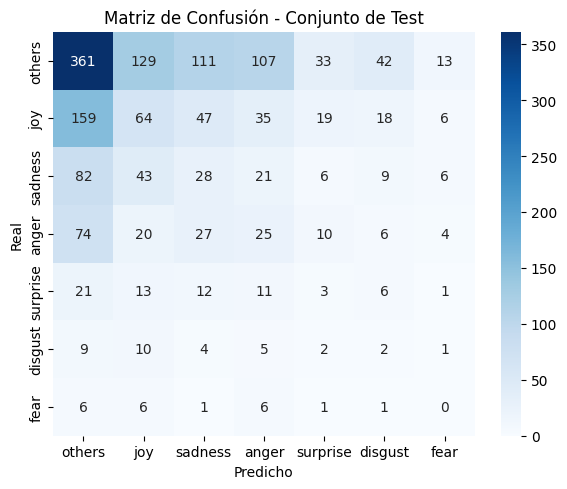

In [90]:
# 2. Matriz de confusión
evaluador.show_confusion_matrix(
    test_true_emotions, 
    test_pred_emotions, 
    title="Matriz de Confusión - Conjunto de Test"
)

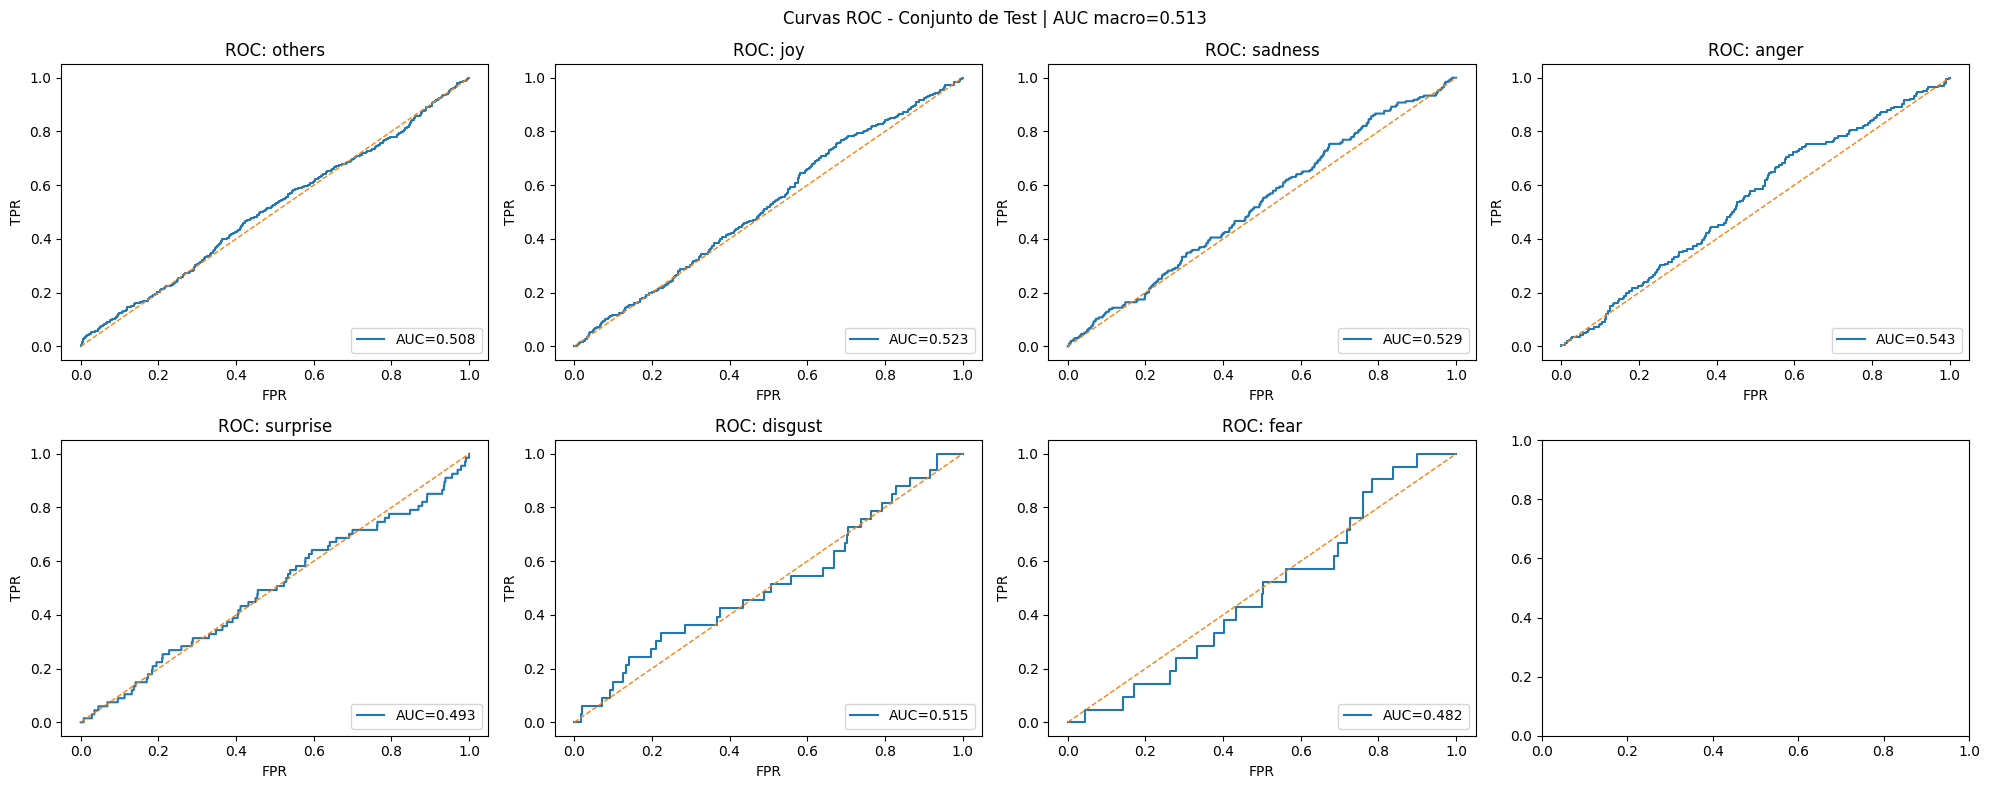

In [94]:
# 3. Curvas ROC
evaluador.show_roc_curves(
    test_true_emotions, 
    test_probs, 
    title="Curvas ROC - Conjunto de Test"
)

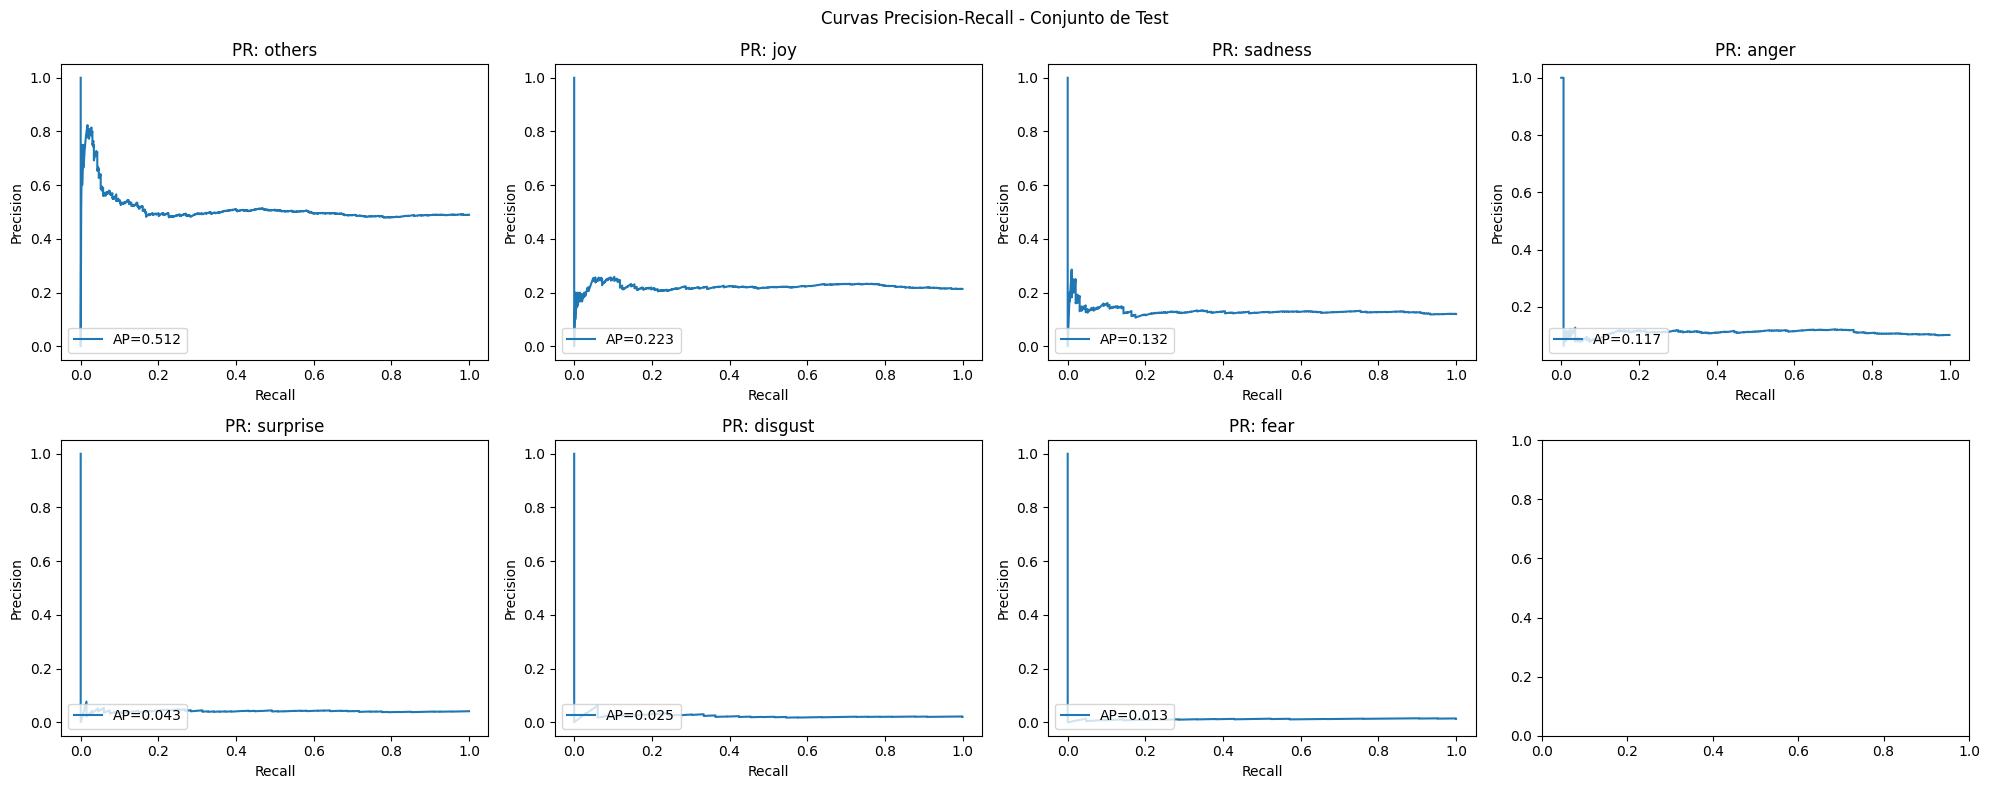

In [95]:
# 4. Curvas Precision-Recall
evaluador.show_pr_curves(
    test_true_emotions, 
    test_probs, 
    title="Curvas Precision-Recall - Conjunto de Test"
)

In [96]:
# 5. Análisis por evento
evaluador.show_event_analysis(
    test_clean, 
    test_probs, 
    y_col="emotion", 
    event_col="event", 
    title="Análisis por Evento - Conjunto de Test"
)

== Análisis por Evento - Conjunto de Test ==

Evento: ChampionsLeague
  Accuracy:        0.3405
  F1-macro:        0.1347
  Precision-macro: 0.1363
  Recall-macro:    0.1413


,Real,Pred
others,99,140
joy,63,51
sadness,27,3
anger,30,19
surprise,5,11
disgust,6,5
fear,2,3



Evento: GameOfThrones
  Accuracy:        0.2466
  F1-macro:        0.1171
  Precision-macro: 0.1219
  Recall-macro:    0.1227


,Real,Pred
others,104,86
joy,47,33
sadness,27,17
anger,22,32
surprise,10,37
disgust,6,9
fear,3,5



Evento: GretaThunberg
  Accuracy:        0.4604
  F1-macro:        0.1863
  Precision-macro: 0.2116
  Recall-macro:    0.1890


,Real,Pred
others,68,100
joy,28,13
sadness,22,9
anger,12,10
surprise,6,2
disgust,1,5
fear,2,0



Evento: LaLiga
  Accuracy:        0.3697
  F1-macro:        0.1399
  Precision-macro: 0.1415
  Recall-macro:    0.1438


,Real,Pred
others,57,66
joy,32,38
sadness,7,4
anger,13,5
surprise,5,3
disgust,3,3
fear,2,0



Evento: NotreDame
  Accuracy:        0.1822
  F1-macro:        0.1401
  Precision-macro: 0.1914
  Recall-macro:    0.1955


,Real,Pred
others,122,28
joy,38,1
sadness,26,151
anger,23,24
surprise,12,4
disgust,4,17
fear,0,0



Evento: SpainElection
  Accuracy:        0.3211
  F1-macro:        0.1328
  Precision-macro: 0.1362
  Recall-macro:    0.1353


,Real,Pred
others,107,91
joy,46,44
sadness,21,8
anger,22,46
surprise,12,9
disgust,5,5
fear,5,15



Evento: Venezuela
  Accuracy:        0.2821
  F1-macro:        0.1273
  Precision-macro: 0.1483
  Recall-macro:    0.1774


,Real,Pred
others,124,99
joy,42,9
sadness,30,21
anger,21,67
surprise,10,2
disgust,3,30
fear,4,6



Evento: WorldBookDay
  Accuracy:        0.2708
  F1-macro:        0.1014
  Precision-macro: 0.0997
  Recall-macro:    0.1122


,Real,Pred
others,115,102
joy,52,96
sadness,35,17
anger,23,7
surprise,7,6
disgust,5,10
fear,3,2
